<a href="https://colab.research.google.com/github/AutoViML/lazytransform/blob/main/Featurewiz_LazyTransform_Demo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lazytransform --ignore-installed --no-deps
!pip install category-encoders --ignore-installed --no-deps
!pip install featurewiz --ignore-installed --no-deps
### you need xlrd since colab for some reason doesn't have it
!pip install xlrd

# This is a LazyTransformer demo along with FeatureWiz

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
np.random.seed(0)

In [2]:
#####   Use this for debugging/development version ############
import featurewiz as FW

Imported lazytransform v1.16. 

Imported featurewiz 0.5.7. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True,
        		category_encoders="auto", auto_encoders='VAE', ae_options={},
        		add_missing=False, imbalanced=False, verbose=0)
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    


In [3]:
from lazytransform import LazyTransformer

In [4]:
from sklearn.datasets import load_diabetes
#bunch = load_boston()
bunch = load_diabetes()
y = pd.DataFrame(bunch.target, columns=['target'])
X = pd.DataFrame(bunch.data, columns=bunch.feature_names)
print(X.shape, y.shape)
X.head()

(442, 10) (442, 1)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [5]:
target = 'target'
modeltype = 'Regression'

In [6]:
encoders = 'auto'
scalers = 'std'

# LightGBM is used here. But you can use any sklearn model.

In [7]:
import lightgbm as lgbm
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier

params = {
    'force_col_wise': True,
    # other parameters...
}

if modeltype == 'Regression':
    lgb = lgbm.LGBMRegressor(**params, device="cpu")
    if isinstance(target, list):
        if len(target) > 1:
            lgb = MultiOutputRegressor(lgb)
else:
    lgb = lgbm.LGBMClassifier(**params, device="cpu")
    if isinstance(target, list):
        if len(target) > 1:
            lgb = MultiOutputClassifier(lgb)

In [8]:
import featurewiz as FW

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=99)
print(X_train.shape, X_test.shape)

(309, 10) (133, 10)


In [10]:
y_train.head()

,target
74,85.0
418,84.0
344,200.0
190,292.0
237,72.0


# Baseline model with all features - let's see performance

In [11]:
print('all features = %d' %X_train.shape[1])

all features = 10


In [12]:
sim = LazyTransformer(model=lgb, encoders='auto',scalers=scalers, imbalanced=False, combine_rare=False)
sim

In [13]:
### If using a model in pipeline, use fit and predict only ###
sim.fit(X_train, y_train)

    Single_Label Regression problem 
Shape of dataset: (309, 10). Now we classify variables into different types...
Time taken to define data pipeline = 1 second(s)
[LightGBM] [Info] Total Bins 537
[LightGBM] [Info] Number of data points in the train set: 309, number of used features: 10
[LightGBM] [Info] Start training from score 151.990291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [14]:
### If using a model in pipeline, use fit and predict only ###
predictions = sim.predict(X_test)

In [15]:
import sklearn
if modeltype == 'Regression':
    print('R-squared = %0.0f%%' %(100*sklearn.metrics.r2_score(y_test, predictions)))
    print('RMSE = %0.2f' %np.sqrt(sklearn.metrics.mean_squared_error(y_test, predictions)))
else:
    print(sklearn.metrics.classification_report(y_test, predictions))

R-squared = 36%
RMSE = 61.00


# Let's compare it with a model with select features from featurewiz

In [16]:
sim = LazyTransformer(model=lgb, encoders=encoders,scalers='auto', imbalanced=False)
sim

In [17]:
X_train_trans, y_train_trans = sim.fit_transform(X_train, y_train)
X_train_trans.shape

    Single_Label Regression problem 
Shape of dataset: (309, 10). Now we classify variables into different types...
Time taken to define data pipeline = 1 second(s)
[LightGBM] [Info] Total Bins 537
[LightGBM] [Info] Number of data points in the train set: 309, number of used features: 10
[LightGBM] [Info] Start training from score 151.990291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

AttributeError: This 'Pipeline' has no attribute 'transform'

In [18]:
X_test_trans = sim.transform(X_test)
X_test_trans.shape

AttributeError: This 'Pipeline' has no attribute 'transform'

# If you have NLP vars, featurewiz will automatically drop them hence use lazytransform to create word vectors. Hence it is better to run featurewiz first and then lazytransform even in NLP datasets.

In [19]:
features = FW.FeatureWiz(corr_limit=0.70, feature_engg='', category_encoders='', dask_xgboost_flag=False, nrows=None, verbose=2)
X_train_selected = features.fit_transform(X_train_trans, y_train_trans)
X_test_selected = features.transform(X_test_trans)

featurewiz is given 0.7 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['label', 'label']
    final list of scalers given: []


NameError: name 'X_train_trans' is not defined

In [ ]:
select = features.features  ### provides the list of selected features ###
print('Select features = %d' %len(select))
print(select)

Select features = 8
['bmi', 's5', 's4', 'sex', 'bp', 's6', 's1', 'age']


In [ ]:
sim = LazyTransformer(model=lgb, encoders=encoders,scalers=scalers, imbalanced=False)
sim

In [ ]:
### If using a model in pipeline, use fit and predict only ###
sim.fit(X_train_selected, y_train)

#### Single_Label Regression problem ####
Shape of dataset: (353, 8). Now we classify variables into different types...
    no date time variables detected in this dataset
    Time taken to define data pipeline = 1 second(s)
    Data Pipeline is saved as: LazyTransformer_pipeline.pkl in current working directory.
model pipeline fitted with LGBMRegressor model


In [ ]:
### If using a model in pipeline, use fit and predict only ###
predictions = sim.predict(X_test_selected)
predictions[:3]

array([105.25359909, 210.90495523,  90.78370909])

In [ ]:
import sklearn
if modeltype == 'Regression':
    print('R-squared = %0.0f%%' %(100*sklearn.metrics.r2_score(y_test, predictions)))
    print('RMSE = %0.2f' %np.sqrt(sklearn.metrics.mean_squared_error(y_test, predictions)))
else:
    #dicto = {0:'f',1:'t'}
    dicto = {0:0,1:1}
    print(sklearn.metrics.classification_report(y_test, pd.Series(predictions).map(dicto)))

R-squared = 35%
RMSE = 61.84


# So feature selection works better in this case than using all features. You can view the lazytransform pipeline here

In [ ]:
from sklearn import set_config
set_config(display="diagram")
sim.xformer
# If you have a model in the pipeline, do:
sim.modelformer

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('scaler_pipeline',
                                  Pipeline(steps=[('complete_pipeline',
                                                   ColumnTransformer(transformers=[('simpleimputer',
                                                                                    SimpleImputer(fill_value=-99,
                                                                                                  strategy='constant'),
                                                                                    ['bmi',
                                                                                     's5',
                                                                                     's4',
                                                                                     'sex',
                                                                                     'bp',
                                                                                     's6',
                                                                                     's1',
                                                                                     'age'])])),
                                                  ('scaler',
                                                   StandardScaler())])),
                                 ('nlp_pipeline',
                                  Pipeline(steps=[('NLP',
                                                   FunctionTransformer(func=<function create_column_names_onehot at 0x0000021261D08820>,
                                                                       kw_args={'catvars': [],
                                                                                'colsize_dict': {},
                                                                                'datesize_dict': {},
                                                                                'datevars': [],
                                                                                'discretevars': [],
                                                                                'nlpvars': [],
                                                                                'numvars': ['bmi',
                                                                                            's5',
                                                                                            's4',
                                                                                            'sex',
                                                                                            'bp',
                                                                                            's6',
                                                                                            's1',
                                                                                            'age'],
                                                                                'onehot_dict': {}}))]))])),
                ('model', LGBMRegressor(device='cpu'))])

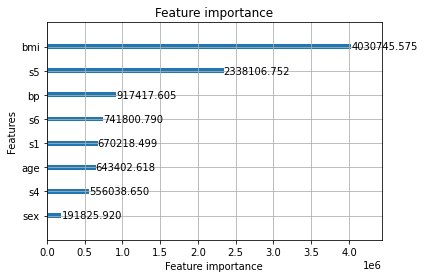

In [ ]:
lazy.plot_importance()